<a href="https://colab.research.google.com/github/mohmaed7777/GoDaddy---Microbusiness-Density-Forecasting/blob/main/Go_daddy_first_submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! cp kaggle.json ~/.kaggle/

In [6]:
! kaggle competitions download -c godaddy-microbusiness-density-forecasting

  0% 0.00/1.83M [00:00<?, ?B/s]
100% 1.83M/1.83M [00:00<00:00, 143MB/s]


In [7]:
! unzip godaddy-microbusiness-density-forecasting.zip

Archive:  godaddy-microbusiness-density-forecasting.zip
  inflating: census_starter.csv      
  inflating: revealed_test.csv       
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
%matplotlib inline
#for dirname, _, filenames in os.walk('/kaggle/input'):
 #   for filename in filenames:
  #      print(os.path.join(dirname, filename))
from xgboost import XGBRegressor

In [9]:
table1 = pd.read_csv('/content/census_starter.csv')
table1.head()

,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,cfips,pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,...,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
0,76.6,78.9,80.6,82.7,85.5,1001,14.5,15.9,16.1,16.7,...,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
1,74.5,78.1,81.8,85.1,87.9,1003,20.4,20.7,21.0,20.2,...,1.4,1.3,1.4,1.0,1.3,52562,55962.0,58320,61756.0,64346.0
2,57.2,60.4,60.5,64.6,64.6,1005,7.6,7.8,7.6,7.3,...,0.5,0.3,0.8,1.1,0.8,33368,34186.0,32525,34990.0,36422.0
3,62.0,66.1,69.2,76.1,74.6,1007,8.1,7.6,6.5,7.4,...,1.2,1.4,1.6,1.7,2.1,43404,45340.0,47542,51721.0,54277.0
4,65.8,68.5,73.0,79.6,81.0,1009,8.7,8.1,8.6,8.9,...,1.3,1.4,0.9,1.1,0.9,47412,48695.0,49358,48922.0,52830.0


In [10]:
table1.shape

(3142, 26)

**Using the stack property of the dataframe to transform the columns into rows. Later, I created an additional column with the year to use this last variable as a parameter of the seaborn plots.**

In [11]:
df_trans = table1.stack().reset_index()
df_trans.columns = ['cfips', 'variable', 'values']
df_trans.head()

,cfips,variable,values
0,0,pct_bb_2017,76.6
1,0,pct_bb_2018,78.9
2,0,pct_bb_2019,80.6
3,0,pct_bb_2020,82.7
4,0,pct_bb_2021,85.5


In [12]:
# splitting variable column per year : 
df_trans["year"]=df_trans.apply(lambda x:x["variable"][-4:],axis=1)
df_trans["var"]=df_trans.apply(lambda x:x["variable"][:-5],axis=1)
df_trans.drop(columns="variable",inplace=True)
df_trans

,cfips,values,year,var
0,0,76.6,2017,pct_bb
1,0,78.9,2018,pct_bb
2,0,80.6,2019,pct_bb
3,0,82.7,2020,pct_bb
4,0,85.5,2021,pct_bb
...,...,...,...,...
81673,3141,59605.0,2017,median_hh_inc
81674,3141,52867.0,2018,median_hh_inc
81675,3141,57031.0,2019,median_hh_inc
81676,3141,53333.0,2020,median_hh_inc


In [13]:
df_trans['year'].unique()

array(['2017', '2018', '2019', '2020', '2021', 'fips'], dtype=object)

In [14]:
df_trans = df_trans[df_trans['year']!= 'fibs']

In [15]:
df_trans['var'].unique()

array(['pct_bb', '', 'pct_college', 'pct_foreign_born', 'pct_it_workers',
       'median_hh_inc'], dtype=object)

# **Training Data:=**

**The main data was loaded on a pandas dataframe on the train variable, with the following columns:**

**cfips, county, and state:** corresponds to the description of each county divided by name and state
**first_day_of_month:** DateTime, useful for the predictions
**microbusiness_density and active:** Both variables represent the total of micro business, but the first is the variable that will be predicted.

In [23]:
train = pd.read_csv('/content/train.csv')
train.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243


In [24]:
# new data: 
act = pd.read_csv('/content/revealed_test.csv')
act.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2022-11-01,1001,Autauga County,Alabama,2022-11-01,3.442677,1463
1,1001_2022-12-01,1001,Autauga County,Alabama,2022-12-01,3.470915,1475
2,1003_2022-11-01,1003,Baldwin County,Alabama,2022-11-01,8.257636,14145
3,1003_2022-12-01,1003,Baldwin County,Alabama,2022-12-01,8.250630,14133
4,1005_2022-11-01,1005,Barbour County,Alabama,2022-11-01,1.247223,247


In [25]:
# appending the new data : 
train = train.append(act, ignore_index=True)

**The first day of the month was transfomered into date:=**

In [26]:
train['date'] = pd.to_datetime(train['first_day_of_month'])

(array([18140., 18262., 18383., 18506., 18628., 18748., 18871., 18993.,
        19113., 19236., 19358.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

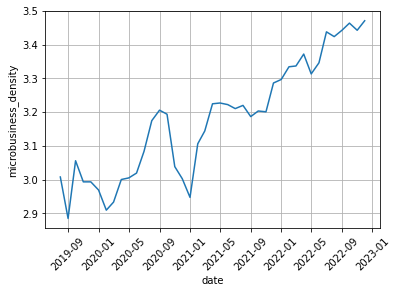

In [27]:
# plotting specific county: 

df_sample = train[train['cfips'] == 1001]

sns.lineplot(data= df_sample, x='date', y='microbusiness_density')
plt.grid()
plt.xticks(rotation=45)

**In this case, the plot shows an increasing trend of micro business, but with the reduction of January 2021, the modeling could be affected. Later, to check if the "active" column follows the same trend an additional plot is presented:**

(array([18140., 18262., 18383., 18506., 18628., 18748., 18871., 18993.,
        19113., 19236., 19358.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

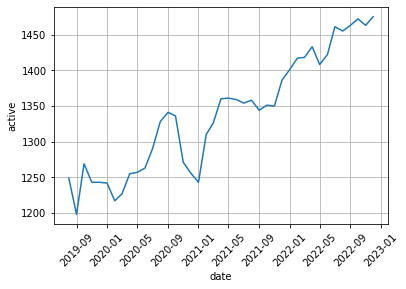

In [28]:
df_sample = train[train['cfips'] == 1001]

sns.lineplot(data=df_sample, x='date', y='active')
plt.grid()

plt.xticks(rotation=45)

**The trend is similar to the other column, showing that, in this initial approach, have a very strong correlation.**